In [1]:

import datetime as dt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotly.express as px
# make plotly visbile in vscode
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import glob

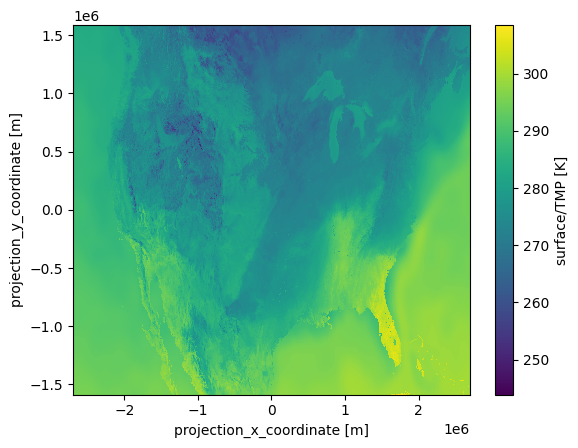

In [2]:
import s3fs 
import xarray 

s3 = s3fs.S3FileSystem(anon=True)
def lookup(path):
    return s3fs.S3Map(path, s3=s3)

path = "hrrrzarr/sfc/20210101/20210101_18z_anl.zarr/surface/TMP" 
ds = xarray.open_mfdataset([lookup(path), lookup(f"{path}/surface")], engine="zarr") 

ds.TMP.plot()

### Explore 5 years of ERA5 atmospheric river data

In [3]:
# get files in ML_GEO_ARs folder as a list
files = glob.glob(f'../data/02_processed/ML_GEO_ARs/*.nc')
# check if WA_ARs file exists
if not glob.glob('../data/02_processed/AR_Events/WA_ARs_events_with_rain.nc'):
    
    wa_mask = xr.open_dataset('../data/02_processed/AR_Events/WA_state_mask.nc')
    df_rainfall = pd.read_csv('../data/02_processed/WA_FINAL_rain_stats.csv', index_col='Date')
    df_rainfall['id'] = [s.split('/')[-1] for s in df_rainfall['AR ID'].values]
    all_ARs = []
    count = 0
    for i,file in enumerate(files):
        # get the name of the AR from the file name
        name = file.split('\\')[-1].split('_')[-1][:-3]
        ds = xr.open_dataset(file)
        # mask lat and lon with wa_mask but keep other variables
        ds_masked = ds.sel(lat=wa_mask.lat, lon=wa_mask.lon, method='nearest')
        
        # if month not in [11,12,1,2,3,4] then continue
        if pd.to_datetime(ds_masked['time'].values[-1]).month not in [11,12,1,2,3,4]:
            continue
        elif name not in df_rainfall['id'].values:
            continue
        else:
            # add n dimension to ds_masked
            ds_masked = ds_masked.assign_coords(event_id=count)
            # drop lat and lon dimensions
            ds_masked = ds_masked.drop_dims(['lat','lon', 'n'])
            # filter values less than zero
            ds_masked = ds_masked.where(ds_masked > 0, drop=True)
            # add rainfall value to ds_masked from df_rainfall
            print(i)
            ds_masked['median_rainfall'] = df_rainfall[df_rainfall['id']==name]["Median Rain [mm/day]"].values[0]
            ds_masked['max_rainfall'] = df_rainfall[df_rainfall['id']==name]["Max Rain [mm/day]"].values[0]
            # append to list
            all_ARs.append(ds_masked)
            count += 1
    # combine all_ARs into one dataset on the time dimension
    wa_ARs_time_ds = xr.concat(all_ARs, dim='time')
    # had issue with duplicated time stamps, so used this method to remove those
    wa_ARs_time_ds = wa_ARs_time_ds.sel(time=~wa_ARs_time_ds.get_index("time").duplicated())
    # make the time dimension a coordinate
    wa_ARs_events_ds = wa_ARs_time_ds.swap_dims({'time':'event_id'})
    # save to netcdf
    wa_ARs_events_ds.to_netcdf('../data/02_processed/AR_Events/WA_ARs_events_with_rain.nc')
    # drop event id coord
    wa_ARs_time_ds = wa_ARs_time_ds.drop_vars('event_id')
    
    # save to netcdf
    wa_ARs_time_ds.to_netcdf('../data/02_processed/AR_Events/WA_ARs_time_with_rain.nc')
else:
    wa_ARs_events_ds = xr.open_dataset('../data/02_processed/AR_Events/WA_ARs_events_with_rain.nc')
    wa_ARs_time_ds = xr.open_dataset('../data/02_processed/AR_Events/WA_ARs_time_with_rain.nc')


8
9
10
11
12
13
17
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
44
45
46
47
48
49
50
51
52
53
54
55
56
65
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
91


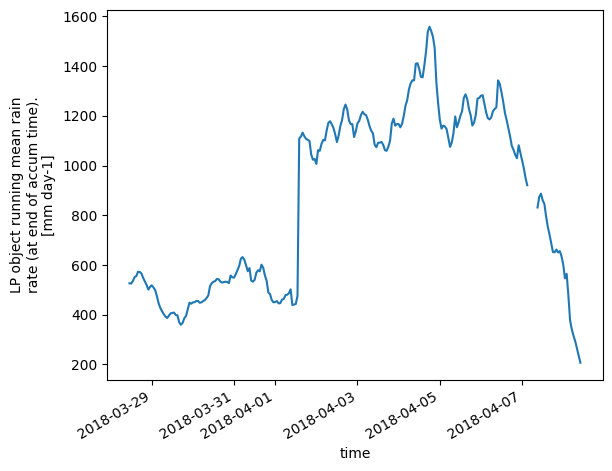

In [4]:
wa_ARs_events_ds.where(wa_ARs_events_ds.time.dt.year==2018, drop=True).sel(event_id=64)['max_running_field'].plot(x='time')

Total number of events in 2016:  11


<Axes: >

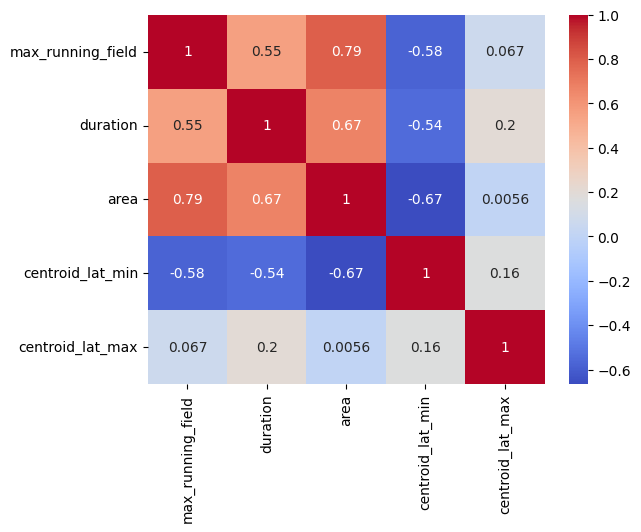

In [5]:
year = 2016
print(f'Total number of events in {year}: ', len(np.unique(wa_ARs_events_ds.where(wa_ARs_events_ds.time.dt.year==year, drop=True)['event_id'].to_numpy())))
event_list = []
wa_ARs_df = wa_ARs_events_ds.to_dataframe()
cols_to_exclude = [ 'amean_inst_field', 'volrain_global_tser',
                    'volrain_at_end_time_tser', 'volrain_with_filter_at_end_time_tser']
# groupby event_id and get the max value of max_running_field, the start, end and count of time
wa_AR_events_df = wa_ARs_df.groupby('event_id').agg({'max_running_field':'max', 'time':['min','max','count'], 'area':'max', 'centroid_lat':['min','max']})

# make a sub dataframe with the max running field, time count, area max, and centroid lat min and max
corr_df = pd.concat([wa_AR_events_df['max_running_field']['max'],
                     wa_AR_events_df['time']['count'],
                     wa_AR_events_df['area']['max'],
                     wa_AR_events_df['centroid_lat']['min'],
                     wa_AR_events_df['centroid_lat']['max']], axis=1)
# rename columns
corr_df.columns = ['max_running_field', 'duration', 'area', 'centroid_lat_min', 'centroid_lat_max']

sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm')

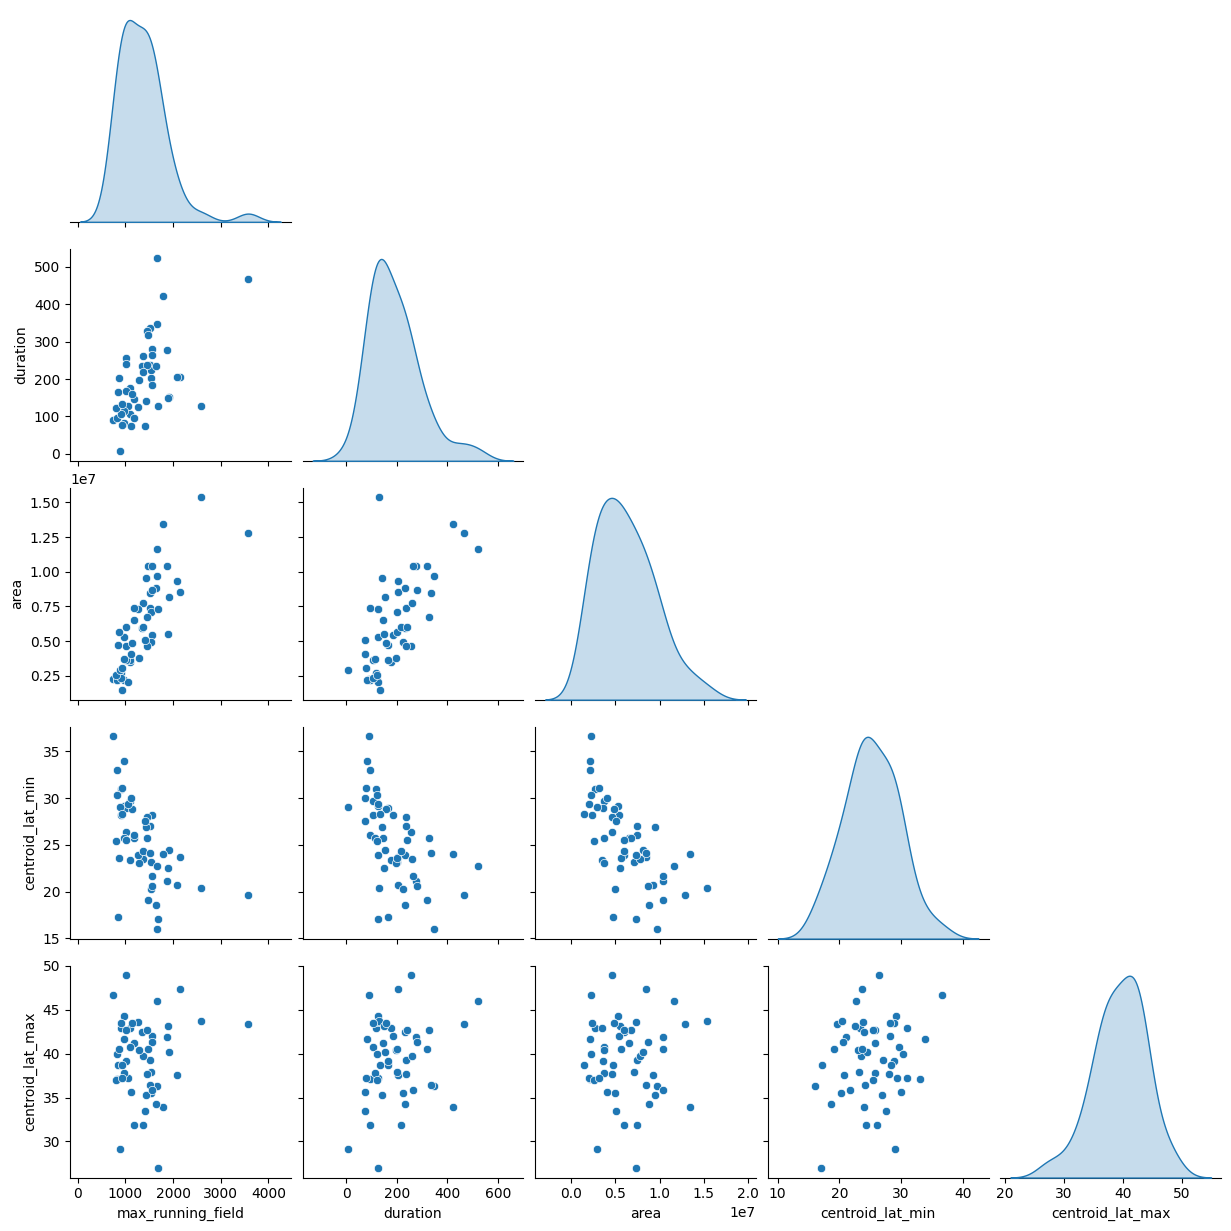

In [6]:
# create a correllogram to look for correlations between variables
sns.pairplot(corr_df, diag_kind='kde', corner=True)

Text(0.5, 1.0, 'Number of AR Events by Month (WY 2015-2018)')

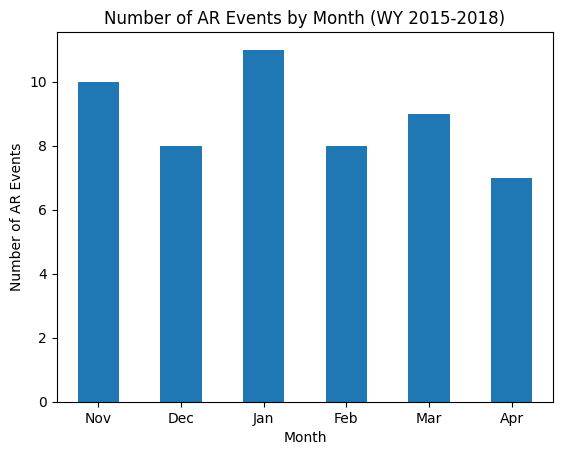

In [7]:
# now get the distribution of events over the months they started in
# reorder the x axis so it goes 10,11,12,1,2,3,4
wa_AR_events_df['time']['max'].dt.month.value_counts().reindex([11,12,1,2,3,4]).plot(kind='bar')
# set the xticks to be the month names
plt.xticks(np.arange(6), ['Nov','Dec','Jan','Feb','Mar','Apr'], rotation=0);
plt.xlabel('Month')
plt.ylabel('Number of AR Events')
plt.title('Number of AR Events by Month (WY 2015-2018)')

### Working with ERA-Interim-AR-Classification data
This data was taken from a paper repository for [this publication]([https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022JD037180).

In [8]:
# first see if ARscale_spatial_filtered is a file
if os.path.isfile('../data/02_processed/ERA-Interim-AR-Classification/ARscale_spatial_filtered.nc'):
    print(f'File exists, opening ARscale_spatial_filtered.nc...')
    ds_filter_01 = xr.open_dataset(f'../data/02_processed/ERA-Interim-AR-Classification/ARscale_spatial_filtered.nc')
else:
    print('Need to create file...')
    ds = xr.open_dataset(f'../data/02_processed/ERA-Interim-AR-Classification/ARscale.nc')
    ds_filter_01 = ds.where((ds.lon > 235) & 
                        (ds.lon < 240) &
                        (ds.lat > 45) & 
                        (ds.lat < 52), drop=True)
    # save as a new file
    ds_filter_01.to_netcdf(f'../data/02_processed/ERA-Interim-AR-Classification/ARscale_spatial_filtered.nc')



File exists, opening ARscale_spatial_filtered.nc...


In [9]:
# drop nans for time, but not all cells need to have data
ds_filter_02 = ds_filter_01.scale.squeeze().dropna(dim='time', how='all')
# filter to the years since water year 2015
ds_filter_03 = ds_filter_02.where((ds_filter_02.time.dt.year > 2013) &
                                  (ds_filter_02.time.dt.year < 2019) &
                                  (ds_filter_02.time.dt.month.isin([11,12,1,2,3,4])) &
                                  (ds_filter_02.time.dt.date > dt.date(2014,10,31)) &
                                  (ds_filter_02.time.dt.date < dt.date(2018,5,1)) &
                                  (ds_filter_02>0), drop=True)
# take the zonal and meridional median values
# this essentially will take the median value within the grid cells we defined as 
ds_filter_04 = ds_filter_03.median(dim='lon').median(dim='lat')
# conert to integer values and drop values less than 1
ds_filter_05 = ds_filter_04.astype(int)

In [10]:
# convert to a dataframe
df = ds_filter_05.to_dataframe()
# add a column for the date
df['date'] = df.index.date
# add a column as time difference from the previous index
df['time_diff'] = df.index.to_series().diff().dt.days

# iterate through the time_diff column, if the value is zero, store the same event id value, if the value is non-zero, add 1 to the event_id and store the value
event_id = 0
event_list = []
for val in df.time_diff:
    if val == 0:
        event_list.append(event_id)
    else:
        event_id += 1
        event_list.append(event_id)
# add event_id column to the dataframe
df['event_id'] = event_list


Text(0.5, 1.0, 'Distribution of AR Scale for Events in the PNW between 2015 and 2019')

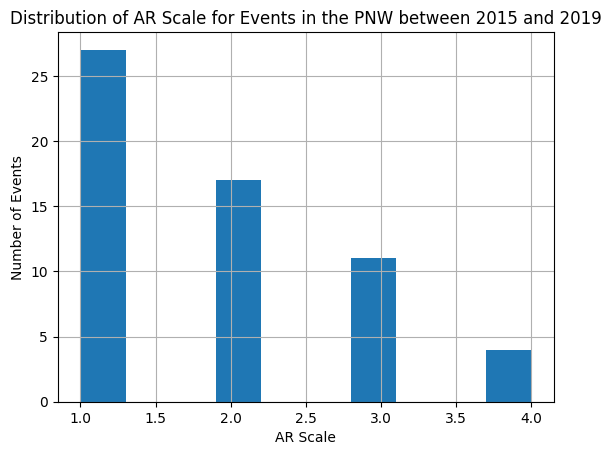

In [11]:
# groupby event ids
grouped_df = df.groupby('event_id').agg({'date': ['first', 'last'], 'time_diff': 'count', 'scale': 'max'})
# multiply time_diff by 6 to get the duration in hours
grouped_df['duration'] = grouped_df['time_diff'] * 6
grouped_df['scale'].hist()
# add x and y labels
plt.xlabel('AR Scale')
plt.ylabel('Number of Events')
# add a title
plt.title('Distribution of AR Scale for Events in the PNW between 2015 and 2019')

### Find the events in our dataset that are mathc the length and time of the ERA-5 Intermin dataset

In [12]:
# make time a dimension of the dataset
# create an empty dataframe with columns of max_running_field, duration, area, centroid_lat_min, centroid_lat_max, event_id
era5_matched_ar_event_df = pd.DataFrame(columns=['event_start_time','max_ivt', 'duration', 'area','max_prcp', 'centroid_lat_min', 'centroid_lat_max','validation_scale'])
# initialize event_id to 1
missed_events = []
for event in grouped_df.index:
    # grab a row of the era5-interim dataset
    tmp = grouped_df.loc[event]
    event_id = tmp.name

    # create a period the length of the duration from the start
    period = pd.period_range(start=tmp['date']['first'], periods=tmp['duration'].values[0]+1, freq='H').to_timestamp().astype('datetime64[ns]')
    try:
        # sel the time variable to the period   
        tmp_df = wa_ARs_time_ds.sel(time=period).to_dataframe()
        # add rainfall 

        # get ({'max_running_field':'max', 'max_running field': 'count', 'area':'max', 'centroid_lat':['min','max']})
        event_max_running_field = tmp_df['max_running_field'].max()
        event_count = tmp_df['max_running_field'].count()
        event_area = tmp_df['area'].max()
        event_prcp = tmp_df['max_rainfall'].max()
        event_centroid_lat_min = tmp_df['centroid_lat'].min()
        event_centroid_lat_max = tmp_df['centroid_lat'].max()
        # add start time
        event_start_time = tmp_df.index[0]
        ar_strength = tmp['scale']['max']

        # add the values as a row to the dataframe
        era5_matched_ar_event_df.loc[event_id] = [event_start_time,event_max_running_field, event_count, 
                                                  event_area, event_prcp, event_centroid_lat_min, 
                                                  event_centroid_lat_max, ar_strength]
    except:
        print('error with event_id: ', event_id)
        missed_events.append(event_id)




error with event_id:  5
error with event_id:  32
error with event_id:  35
error with event_id:  36
error with event_id:  46
error with event_id:  49


### Working with ERA5 atmospheric data

In [13]:
era5_ds = xr.open_mfdataset(f'../data/01_raw/era5_pressure_levels/era5_*.nc')
era5_single_lvl_ds = xr.open_dataset(f'../data/01_raw/era5_single_level/era5_ivt_2014-2018.nc')
# print the length of the time dimension
print(f'Number of times: ', len(era5_ds.time))

Number of times:  21744


In [104]:
# loop through the event_start and save the time for hour up until the duration of the event
hourly_event_times = []
for event in era5_matched_ar_event_df.index:
    hourly_event_times.append(pd.date_range(start=era5_matched_ar_event_df.loc[event, 'event_start_time'], periods=era5_matched_ar_event_df.loc[event, 'duration'], freq='H'))

# concatenate the list of hourly event times into one array
hourly_event_times_array = np.concatenate(hourly_event_times)
# cross check to see if the length of this array is not greater than the length of the time dimension
print(f'Number of hours with ARs over period: ', len(hourly_event_times_array))

Number of hours with ARs over period:  1961


In [105]:
# select the data from the era5 dataset that matches the hourly_event_times_array
era5_ds_filter = era5_ds.sel(time=hourly_event_times_array, method='nearest')
# select the data from the era5 single level dataset that matches the hourly_event_times_array
era5_single_lvl_ds_filter = era5_single_lvl_ds.sel(time=hourly_event_times_array)
# using the u anv v components of the wind, calculate the arithmatic magnitude and direction of the wind
era5_ds_filter['wind_speed'] = np.sqrt(era5_ds_filter.u**2 + era5_ds_filter.v**2)
era5_ds_filter['wind_dir'] = np.arctan2(era5_ds_filter.u, era5_ds_filter.v) * 180 / np.pi

In [106]:
# combine the two variables into a vector 
era5_single_lvl_ds_filter['ivt'] = np.sqrt(era5_single_lvl_ds_filter['p71.162']**2 + era5_single_lvl_ds_filter['p71.162']**2)

In [107]:
time_for_plot = era5_matched_ar_event_df.iloc[10].event_start_time
time_for_plot

Timestamp('2015-01-23 00:00:00')

c:\Users\dlhogan\OneDrive - UW\Documents\GitHub\MLGeo-2023-Atmospheric-Rivers\venv\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning:

The following kwargs were not used by contour: 'regrid_shape'

c:\Users\dlhogan\OneDrive - UW\Documents\GitHub\MLGeo-2023-Atmospheric-Rivers\venv\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning:

The following kwargs were not used by contour: 'regrid_shape'

c:\Users\dlhogan\OneDrive - UW\Documents\GitHub\MLGeo-2023-Atmospheric-Rivers\venv\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning:

The following kwargs were not used by contour: 'regrid_shape'

c:\Users\dlhogan\OneDrive - UW\Documents\GitHub\MLGeo-2023-Atmospheric-Rivers\venv\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning:

The following kwargs were not used by contour: 'regrid_shape'



Text(0.5, 0.98, '2015-01-16T00:00:00.000000000')

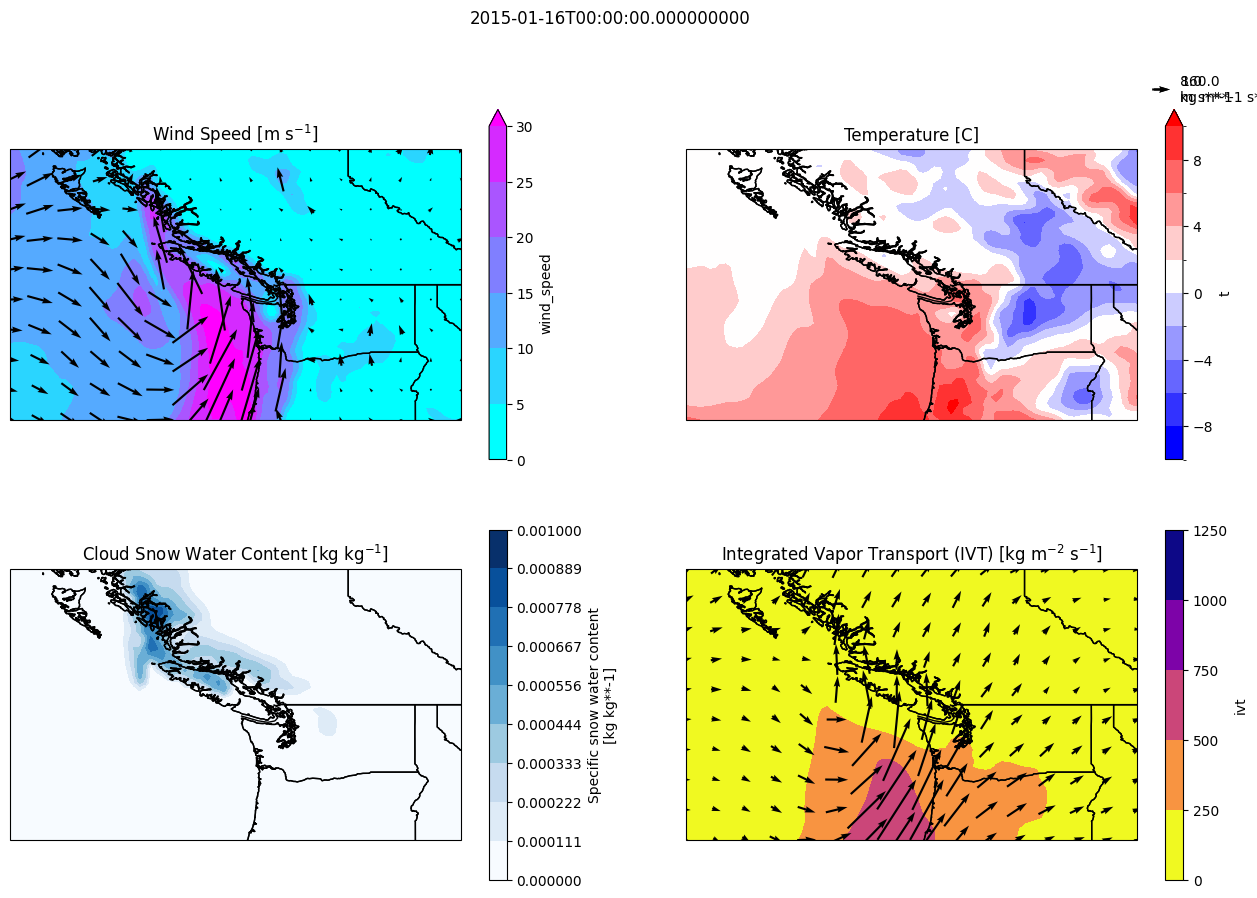

In [108]:
time_for_plot = era5_matched_ar_event_df.iloc[8].event_start_time + pd.Timedelta(hours=24)
# create 4 subplots with ccrs.PlateCarree() as the projection
fig, axs = plt.subplots(2,2, figsize=(16,10), subplot_kw={'projection': ccrs.PlateCarree()})
# set the extent of all plots
axs = axs.flatten()
for ax in axs:
    ax.set_extent([-135, -115, 43, 55], ccrs.PlateCarree())
    # add coastlines to all plots
    ax.coastlines()
    # add state boundaries to all plots
    ax.add_feature(cfeature.STATES)
    # add country boundaries to all plots
    ax.add_feature(cfeature.BORDERS)

# for the first subplot, plot the wind speed at 900 hPa
# plot the wind speed at the first time step for the first level using contourf
era5_ds_filter.sel(time=time_for_plot, level=900).wind_speed.plot.contourf(transform=ccrs.PlateCarree(), regrid_shape=10, levels=7, cmap='cool', ax=axs[0], vmin=0, vmax=30)
# plot the vectors of u an v wind components at the first time step for the first level using quiver
era5_ds_filter.sel(time=time_for_plot, level=900).plot.quiver('longitude', 'latitude', 'u', 'v', transform=ccrs.PlateCarree(), regrid_shape=10, ax=axs[0] )
# add title
axs[0].set_title('Wind Speed [m s$^{-1}$]')

# for the second subplot, plot the temperature at 900 hPa
# convert from kelvin to celsius and make the colorabar every 5 degrees
(era5_ds_filter.sel(time=time_for_plot, level=900).t - 273.15).plot.contourf(transform=ccrs.PlateCarree(), regrid_shape=10, levels=11, cmap='bwr', ax=axs[1], vmin=-10, vmax=10)
# add title
axs[1].set_title('Temperature [C]')

# plot the countours of the total cloud snow water content
era5_ds_filter.sel(time=time_for_plot, level=900).cswc.plot.contourf(transform=ccrs.PlateCarree(), regrid_shape=10, levels=10, cmap='Blues', ax=axs[2], vmin=0, vmax=0.001)
# add title
axs[2].set_title('Cloud Snow Water Content [kg kg$^{-1}$]')

# plot the contours of ivt 
era5_single_lvl_ds_filter.sel(time=time_for_plot).ivt.plot.contourf(transform=ccrs.PlateCarree(), regrid_shape=10, levels=6, cmap='plasma_r', ax=axs[3], vmin=0, vmax=1250)
era5_single_lvl_ds_filter.sel(time=time_for_plot).plot.quiver('longitude', 'latitude', 'p71.162', 'p72.162', transform=ccrs.PlateCarree(), regrid_shape=10, ax=axs[3] )
# make sure the units appear in the colorbar
axs[3].set_title('Integrated Vapor Transport (IVT) [kg m$^{-2}$ s$^{-1}$]')
# add a fig title for the time
fig.suptitle(era5_ds_filter.sel(time=time_for_plot).time.values)

In [14]:

# open the snotel dataset
wa_snotel_ds = xr.open_dataset('../data/01_raw/snotel/data_snotel_wa_4000ft.nc')

# locations 
sntl_locs = wa_snotel_ds.isel(time=0).to_dataframe().reset_index()
# using plotly, plot the location of the snotel stations
fig = px.scatter_geo(sntl_locs, lat="lat", lon="lon", hover_name="site", hover_data=["elevation"], color_discrete_sequence=["fuchsia"],
                     # add extent of map to be the PNW
                    scope='usa', center={'lat': 47.5, 'lon': -120},
                     # make 600 x 400
                     width=600, height=400)
# overlay north america
fig.update_geos(showcountries=True, countrycolor="Black",
                showsubunits=True, subunitcolor="Blue",
                fitbounds="locations")
# add the state boundaries
fig.show()

In [15]:
# create an empty dataframe with the same index as event_df and the columns as the snotel stations
snotel_ar_event_df = pd.DataFrame(index=era5_matched_ar_event_df.index, columns=wa_snotel_ds.site)
# for each event in the event_df, get the difference in snow depth between the start and end of the event
for event in era5_matched_ar_event_df.index:
    # get the start time of the event
    starttime = era5_matched_ar_event_df.loc[event]['event_start_time'].date()
    # set the endtime as the date of the difference in duration
    endtime = (era5_matched_ar_event_df.loc[event]['event_start_time'] + pd.Timedelta(hours=era5_matched_ar_event_df.loc[event]['duration'])).date()
    # if endtime is less than 1 day later, make end time one day later
    if endtime == starttime:
        print('endtime is less than one day later, adding one day to endtime')
        endtime = starttime + pd.Timedelta(days=1)
    # get the snow depth at the start of the event
    snow_depth_start = wa_snotel_ds.sel(time=starttime, method='nearest').SNOWDEPTH
    # get the snow depth at the end of the event
    snow_depth_end = wa_snotel_ds.sel(time=endtime, method='nearest').SNOWDEPTH
    # get the difference in snow depth
    snow_depth_diff = snow_depth_end - snow_depth_start
    # add this to the event_df
    snotel_ar_event_df.loc[event] = snow_depth_diff


endtime is less than one day later, adding one day to endtime
endtime is less than one day later, adding one day to endtime
endtime is less than one day later, adding one day to endtime
endtime is less than one day later, adding one day to endtime
endtime is less than one day later, adding one day to endtime
endtime is less than one day later, adding one day to endtime
endtime is less than one day later, adding one day to endtime
endtime is less than one day later, adding one day to endtime
endtime is less than one day later, adding one day to endtime
endtime is less than one day later, adding one day to endtime
endtime is less than one day later, adding one day to endtime
endtime is less than one day later, adding one day to endtime
endtime is less than one day later, adding one day to endtime
endtime is less than one day later, adding one day to endtime


<Axes: >

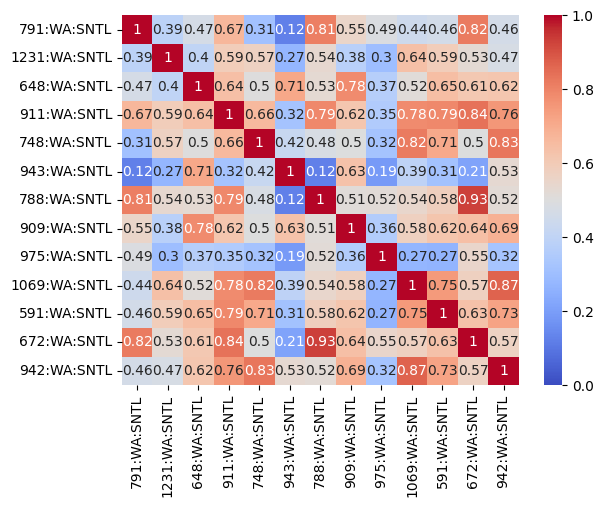

In [16]:
sns.heatmap(snotel_ar_event_df.corr(), annot=True, cmap='coolwarm', vmin=0, vmax=1)

In [17]:
# drop sites with average correlation below 0,5
highly_correlated_sites = (snotel_ar_event_df.corr().mean()>0.55)
cols = highly_correlated_sites[highly_correlated_sites==True].index
snotel_ar_event_df = snotel_ar_event_df[cols]
# create a snow, no snow series on each event, if the sum of the sites was greater than 0
ar_snowfall_snow_binary_mask = pd.Series(np.where(snotel_ar_event_df.mean(axis=1)>0, 1, 0), index=snotel_ar_event_df.index)


Text(0.5, 1.0, 'Distribution of Median Snow Depth Change at ~ 1200 m.a.s.l. SNOTEL sites\nfor AR Events in the PNW between 2015 and 2019')

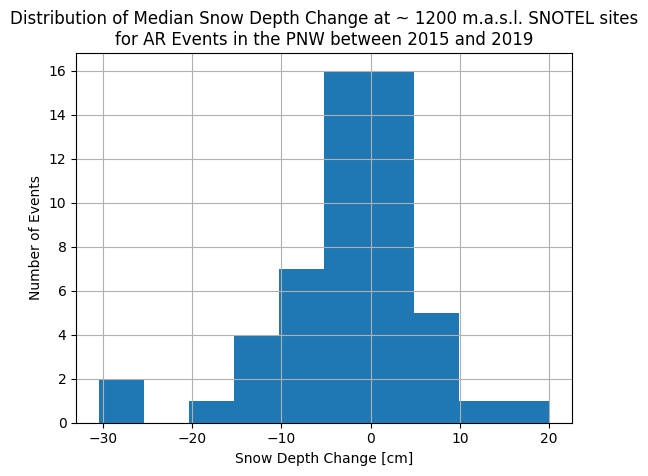

In [18]:
snotel_ar_event_df.mean(axis=1).hist()
# add x and y labels
plt.xlabel('Snow Depth Change [cm]')
plt.ylabel('Number of Events')
# add a title
plt.title('Distribution of Median Snow Depth Change at ~ 1200 m.a.s.l. SNOTEL sites\nfor AR Events in the PNW between 2015 and 2019')

### Create our dataset

In [19]:
era5_matched_ar_event_df['snow_no_snow'] = ar_snowfall_snow_binary_mask


<Axes: xlabel='max_ivt', ylabel='centroid_lat_max'>

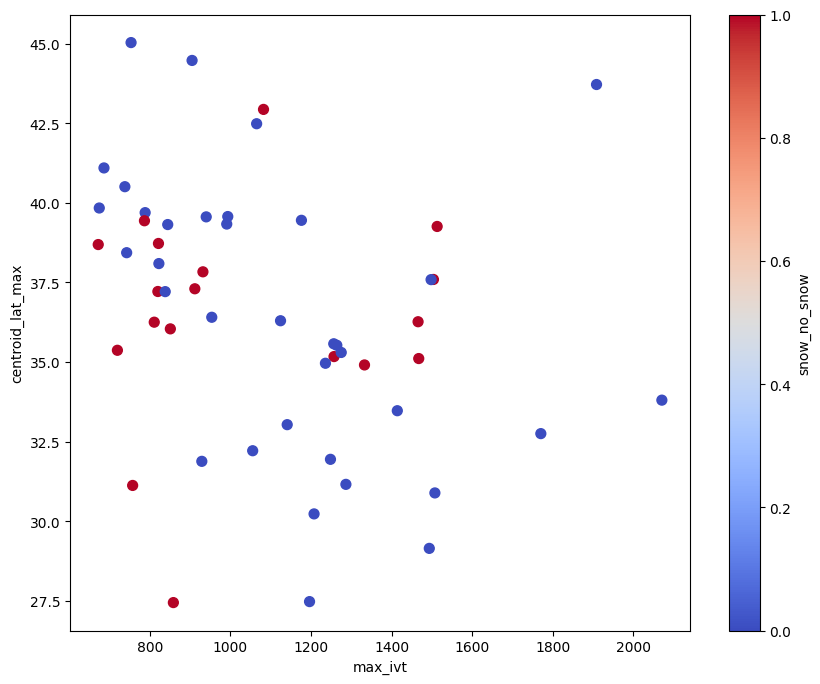

In [27]:
era5_matched_ar_event_df.plot.scatter(x='max_ivt', y='centroid_lat_max', c='snow_no_snow', cmap='coolwarm', s=50, figsize=(10,8))

In [28]:
era5_matched_ar_event_df.to_csv('../data/02_processed/era5_matched_ar_events.csv')